In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import copy
from re import sub
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas
import pycountry
pd.set_option('display.max_columns', None)


In [29]:
def curr_to_dec(money):
    return float(sub(r'[^\d.]', '', money))

In [30]:
def gdp_preproc(gdp_df):
    gdp_df = gdp_df[['GDP (nominal, 2017)','GDP per capita','Country']]
    gdp_df['GDP (nominal, 2017)'] = gdp_df['GDP (nominal, 2017)'].apply(curr_to_dec)
    gdp_df['GDP per capita'] = gdp_df['GDP per capita'].apply(curr_to_dec)
    return gdp_df
def preproc_col(df):
    return df.rename(columns={"Country,Other":"Country"}).drop(columns=['Unnamed: 0'])
def merge_gdp(df,gdp_df=pd.read_csv("./data/gdp.csv")): 
    return gdp_preproc(gdp_df).merge(df,on='Country')
def add_death_per_cases(df):
    df['Deaths/Cases'] = df['TotalDeaths']/df['TotalCases']
    return df
def duy_preproc(df):
    result = copy.deepcopy(df)
    result = result.drop(df.tail(8).index)    
    result = preproc_col(result)
    result = add_death_per_cases(result)
    result = merge_gdp(result)
    return result

In [31]:
df = pd.read_csv('./data/2022-04-27.csv')
df = duy_preproc(df)

/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
df = df.dropna(axis=0,subset=['Deaths/1M pop','Tot\xa0Cases/1M pop'])

In [34]:
df_1 = df[["GDP per capita","Deaths/Cases"]]

<AxesSubplot:xlabel='GDP (nominal, 2017)', ylabel='Deaths/Cases'>

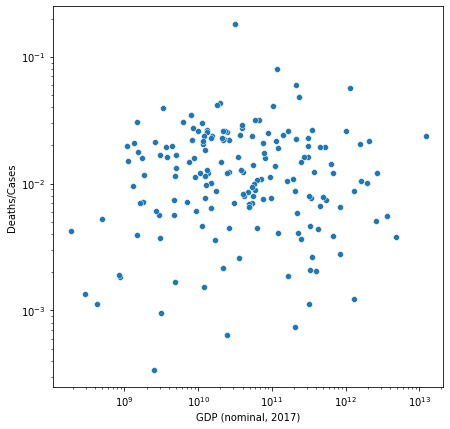

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='GDP (nominal, 2017)', y='Deaths/Cases', data=df,ax = ax)

In [49]:
df['Country']

0         China
1         Japan
2       Germany
3         India
4        France
         ...   
166       Samoa
167    Dominica
168       Tonga
170       Palau
172    Kiribati
Name: Country, Length: 170, dtype: object

In [54]:
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
df['CODE'] = alpha3code(df['Country'])

/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


In [56]:
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,df,on='CODE')
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name')

In [61]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    print(world['name'])

0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
5                    Kazakhstan
6                    Uzbekistan
7              Papua New Guinea
8                     Indonesia
9                     Argentina
10                        Chile
11              Dem. Rep. Congo
12                      Somalia
13                        Kenya
14                        Sudan
15                         Chad
16                        Haiti
17               Dominican Rep.
18                       Russia
19                      Bahamas
20                 Falkland Is.
21                       Norway
22                    Greenland
23       Fr. S. Antarctic Lands
24                  Timor-Leste
25                 South Africa
26                      Lesotho
27                       Mexico
28                      Uruguay
29                       Brazil
30                      Bolivia
31      

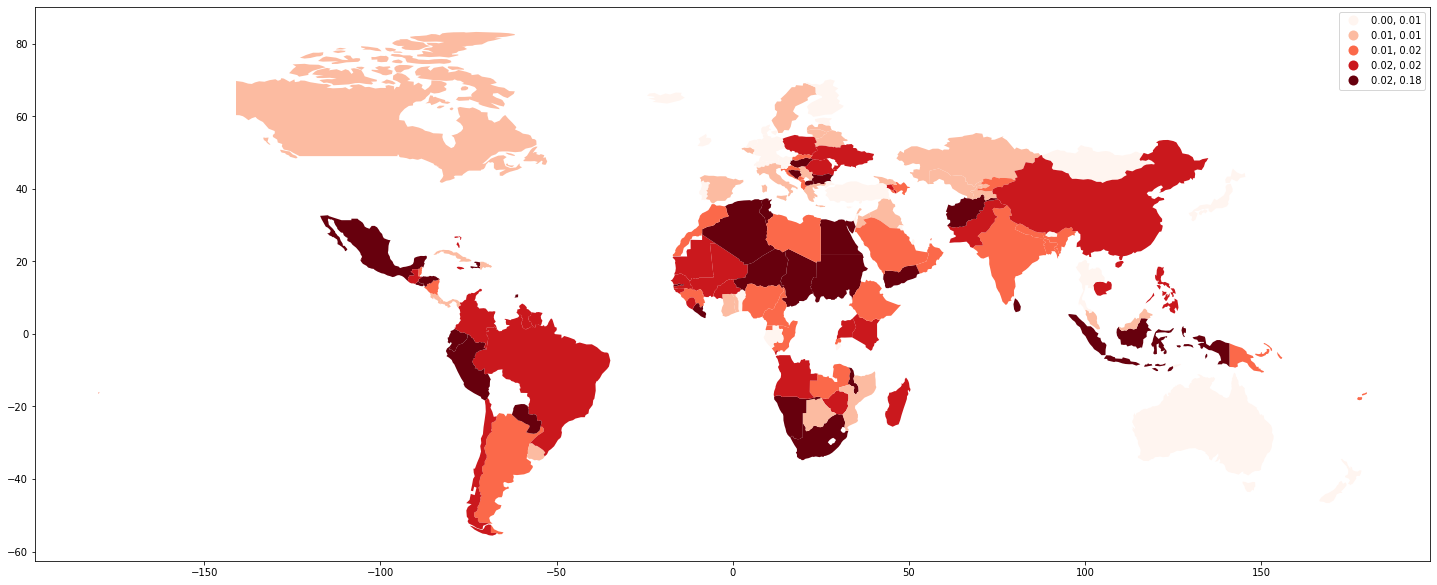

In [57]:
# plot confirmed cases world map 
merge.plot(column='Deaths/Cases', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='Reds')
# add countries names and numbers 

plt.show()

In [ ]:
# plot confirmed cases world map 
merge.plot(column='Tot\xa0Cases/1M pop', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='Reds')
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge['Deaths/Cases'][i]),size=10)
plt.show()

In [ ]:

f, ax = plt.subplots(figsize=(7, 7))

sns.regplot(x='Tot\xa0Cases/1M pop', y='Deaths/Cases', data=df,ax = ax)

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='GDP (nominal, 2017)', y='Deaths/Cases', data=df,ax = ax)

In [ ]:
w = np.ones(len(df))
w[len(df) * 6 // 10 :] = 2
w

In [ ]:
Y = stats.zscore(df['Deaths/Cases'])
X = stats.zscore(df['Tot\xa0Cases/1M pop'])
model_OLS = sm.OLS(Y,X)
result_OLS = model_OLS.fit()
result_OLS.summary()

In [ ]:
Y_pred = result_OLS.predict(X)

In [ ]:
_std = np.sqrt((Y-Y_pred)**2)
_std

In [ ]:
sns.lineplot(x = X,y = _std)

In [ ]:
from sklearn.cluster import KMeans
X = merge[["Deaths/Cases","Tot\xa0Cases/1M pop"]]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
merge['label'] = kmeans.labels_

In [ ]:
# plot confirmed cases world map 
merge.plot(column='label', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='seismic')
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge['Deaths/Cases'][i]),size=10)
plt.show()

In [ ]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

print(f"{type(df_world)}, {df_world.geometry.name}")

print(df_world.head())

print(df_world.geometry.geom_type.value_counts())

In [ ]:
df_world.plot(figsize=(10,6))


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    print(df_world)